In [1]:
import pandas as pd
import numpy as np

In [1]:
from google.colab import files
uploads = files.upload()

Saving p000001.psv to p000001.psv


# Data Read

In [17]:
import requests
from bs4 import BeautifulSoup
import pandas as pd


def scrape_data(url):
    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the <pre> tag with class="plain"
        pre_tag = soup.find('pre', class_='plain')

        # Extract the text content if pre_tag is found
        if pre_tag:
            data = pre_tag.text.strip()  # Strip to remove leading/trailing whitespace
            return data
        else:
            print(f"No data found for URL: {url}")
            return None
    else:
        print(f"Failed to fetch data from {url}. Status code: {response.status_code}")
        return None

# URLs to scrape
base_url = "https://physionet.org/content/challenge-2019/1.0.0/training/training_setA/p"
num_links = 20643
urls = [f"{base_url}{i:06d}.psv" for i in range(1, num_links + 1)]

# List to store scraped data
scraped_data_list = []

# Iterate through the URLs
for url in urls:
    # print(url)
    # Scrape data from the URL
    scraped_data = scrape_data(url)

    # Append the scraped data to the list
    if scraped_data:
        scraped_data_list.append(scraped_data)

# Print the number of scraped data items
print(f"Number of scraped data items: {len(scraped_data_list)}")


Failed to fetch data from https://physionet.org/content/challenge-2019/1.0.0/training/training_setA/p019313.psv. Status code: 404
Failed to fetch data from https://physionet.org/content/challenge-2019/1.0.0/training/training_setA/p020001.psv. Status code: 404
Failed to fetch data from https://physionet.org/content/challenge-2019/1.0.0/training/training_setA/p020002.psv. Status code: 404
Failed to fetch data from https://physionet.org/content/challenge-2019/1.0.0/training/training_setA/p020003.psv. Status code: 404
Failed to fetch data from https://physionet.org/content/challenge-2019/1.0.0/training/training_setA/p020004.psv. Status code: 404
Failed to fetch data from https://physionet.org/content/challenge-2019/1.0.0/training/training_setA/p020005.psv. Status code: 404
Failed to fetch data from https://physionet.org/content/challenge-2019/1.0.0/training/training_setA/p020006.psv. Status code: 404
Failed to fetch data from https://physionet.org/content/challenge-2019/1.0.0/training/trai

In [53]:
import csv

# Specify the file path
file_path = "scraped_data.csv"

# Write the scraped data to a CSV file
with open(file_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["Data"])  # Write header if needed
    writer.writerows([[data] for data in scraped_data_list])

print(f"Data has been saved to {file_path}")

Data has been saved to scraped_data.csv


In [56]:
# Specify the file path
file_path = "scraped_data.csv"

# Write the scraped data to a CSV file
with open(file_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    for data in scraped_data_list:
        writer.writerow([str(data)])

print(f"Data has been saved to {file_path}")

Data has been saved to scraped_data.csv


In [57]:
from google.colab import files

files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:

dfs = []
for scraped_data in scraped_data_list:
  scraped_data_lines = scraped_data.split("\n")
  data_values = [line.split('|') for line in scraped_data_lines]
  columns = data_values[0]
  df = pd.DataFrame(data_values[1:], columns=columns)

  dfs.append(df)

In [20]:
dfs = []
majority_sepsis_labels = []

for scraped_data in scraped_data_list:
    scraped_data_lines = scraped_data.split("\n")
    data_values = [line.split('|') for line in scraped_data_lines]
    columns = data_values[0]
    df = pd.DataFrame(data_values[1:], columns=columns)

    # Convert 'SepsisLabel' to numeric
    df['SepsisLabel'] = pd.to_numeric(df['SepsisLabel'])

    # Extract first 49 rows
    first_49_rows = df.head(49)

    # Calculate majority SepsisLabel value
    majority_sepsis_label = first_49_rows['SepsisLabel'].mode().iloc[0]

    dfs.append(df)
    majority_sepsis_labels.append(majority_sepsis_label)

In [21]:
import numpy as np

updated_dfs = []
basic_data = []
parameters_size = 41
times_threshold = 49
max_times = 0

for df in dfs:
    value_array = []
    delta_array = []
    mask_array = []
    dataset = []

    last_available_times = np.zeros(parameters_size)
    count = 0

    for index, row in df.iterrows():
        count += 1
        values = row.values
        # Replace 'NaN' strings with 0 and convert to float
        values = [0 if str(val) == 'NaN' else float(val) for val in values]

        deltas = np.zeros(parameters_size)
        mask = np.zeros(parameters_size)

        for i, value in enumerate(values):
            if not np.isnan(value):
                mask[i] = 1
                last_available_times[i] = count

        for i in range(parameters_size):
            deltas[i] = count - last_available_times[i]

        value_array.append(values)
        delta_array.append(deltas)
        mask_array.append(mask)

        if count == times_threshold:
          break

    # Pad arrays if count is less than times_threshold
    while count < times_threshold:
        value_array.append(np.zeros(parameters_size))
        delta_array.append(np.zeros(parameters_size))
        mask_array.append(np.zeros(parameters_size))
        count += 1

    value_array = np.array(value_array).T
    delta_array = np.array(delta_array).T
    mask_array = np.array(mask_array).T

    dataset.append(value_array)
    dataset.append(mask_array)
    dataset.append(delta_array)
    updated_dfs.append(dataset)
    basic_data.append(value_array)

    max_times = max(max_times, count)

print("Max Time Groups:", max_times)


Max Time Groups: 49


# Mean Imputation

In [22]:
def get_mean(parameter_values):
  return np.mean(parameter_values)

In [23]:
import copy
mean_dataset = copy.deepcopy(basic_data)
for data in mean_dataset:
  for parameter_idx in range(parameters_size):
    parameter_data = np.array(data[parameter_idx])
    mean_value = get_mean(parameter_data)
    missing_indices = np.where(parameter_data == 0)
    parameter_data[missing_indices] = mean_value
    data[parameter_idx] = parameter_data

# Forward Imputation

In [45]:
forward_dataset = copy.deepcopy(basic_data)
for data in forward_dataset:
  for parameter_idx in range(parameters_size):
    n_times = len(data[parameter_idx])
    last_value = 0
    for n_time in range(n_times):
      if (n_time==0 and data[parameter_idx][0] == 0):
        continue
      if (data[parameter_idx][n_time]!=0):
        last_value = data[parameter_idx][n_time]
      elif(data[parameter_idx][n_time] == 0):
        data[parameter_idx][n_time] = last_value

# Data Split and data loaders

In [24]:
import numpy as np

def custom_train_test_split(features, labels, test_size, validation_size=0.2, random_state=None):
  if random_state is not None:
    np.random.seed(random_state)

  # Shuffle indices
  indices = np.arange(len(features))
  np.random.shuffle(indices)

  # Calculate the number of test and validation samples
  n_test = int(len(features) * test_size)
  n_validation = int(len(features) * validation_size)

  # Split indices into test, validation, and train sets
  test_indices = indices[:n_test]
  validation_indices = indices[n_test:n_test + n_validation]
  train_indices = indices[n_test + n_validation:]

  # Split data based on indices
  test_data = [features[i] for i in test_indices]
  validation_data = [features[i] for i in validation_indices]
  train_data = [features[i] for i in train_indices]

  # Split labels based on indices
  test_labels = [labels[i] for i in test_indices]
  validation_labels = [labels[i] for i in validation_indices]
  train_labels = [labels[i] for i in train_indices]

  return train_data, train_labels, validation_data, validation_labels, test_data, test_labels

In [25]:
from torch.utils.data import Dataset
import torch

class CustomDataset(Dataset):
  def __init__(self, features, labels) -> None:
    self.features = features
    self.labels = labels

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    sample = self.features[index]
    label = self.labels[index]
    sample = torch.tensor(sample, dtype=torch.float32)
    label = torch.tensor(label, dtype = torch.float32)
    return sample, label

In [26]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

def get_data_loader(dataset, labels_df):
  train_features, train_labels, validation_features, validation_labels, test_features, test_labels = custom_train_test_split(dataset, labels_df, test_size=0.2, validation_size = 0.15)

  print(len(train_features))
  print(len(train_labels))
  train_dataset = CustomDataset(train_features, train_labels)
  validation_dataset = CustomDataset(validation_features, validation_labels)
  test_dataset = CustomDataset(test_features, test_labels)

  train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True)
  validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle = True)
  test_loader = DataLoader(test_dataset, batch_size = 4, shuffle = True)

  return train_loader, validation_loader, test_loader

In [27]:
print(len(majority_sepsis_labels))

20336


In [28]:
train_loader, val_loader, test_loader = get_data_loader(mean_dataset, majority_sepsis_labels)    #final_dataset_df['features'], final_dataset_df)

13219
13219


In [46]:
forward_train_loader, forward_val_loader, forward_test_loader = get_data_loader(forward_dataset, majority_sepsis_labels)

13219
13219


In [60]:
import torch
import torch.nn as nn

class MyGRU(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(MyGRU, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True)
    self.fc1 = nn.Linear(hidden_size, 50)
    self.dropout = nn.Dropout(0.2)
    self.fc2 = nn.Linear(50, 25)
    self.fc3 = nn.Linear(25, 1)
    self.relu = nn.ReLU()
    # self.sigmoid = torch.sigmoid()

  def forward(self, x):
    # h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size) * 0.01
    h0 = torch.normal(0, 0.01, size=(self.num_layers, x.size(0), self.hidden_size))
    out, _ = self.gru(x, h0)
    out = out[:, -1, :]
    out = self.fc1(out)
    out = torch.sigmoid(out)
    out = self.fc2(out)
    out = torch.sigmoid(out)
    out = self.fc3(out)
    out = torch.sigmoid(out)
    # out = torch.sigmoid(out)
    return out

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
lr = 0.01
momentum = 0.9
gamma = 0.1  # Factor by which to reduce the learning rate (e.g., multiply by 0.1)
num_layers = 4
input_size = 41
output_size = 1
hidden_dim = 30

model = MyGRU(input_size, hidden_dim, output_size, num_layers)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# optimizer = optim.Adam(model.parameters(), lr=0.05, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)  # Reduce LR by gamma factor every epoch
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, min_lr=1e-6, verbose=True)
class_weights = torch.tensor([0.7], dtype=torch.float)

loss_function = nn.BCEWithLogitsLoss(pos_weight=class_weights)
num_epochs = 10

def gru_train_model(train_loader, val_loader):

  for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()  # Set the model to training mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Training phase
    for inputs, labels in train_loader:
      optimizer.zero_grad()
      outputs = model(inputs.permute(0, 2, 1)).squeeze()
      labels = labels.float().view(-1)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * inputs.size(0)

      train_predictions = (outputs > 0.5).float()
      correct_predictions += (train_predictions == labels).sum().item()
      total_samples += labels.size(0)

    # Calculate average training loss for the epoch
    train_loss = total_loss / len(train_loader.dataset)
    train_accuracy = correct_predictions / total_samples

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
      for val_inputs, val_labels in val_loader:
        val_outputs = model(val_inputs.permute(0, 2, 1)).squeeze()
        val_labels = val_labels.float().view(-1)
        val_loss += loss_function(val_outputs, val_labels).item() * val_inputs.size(0)

        # Calculate accuracy (optional)
        val_predictions = (val_outputs > 0.5).float()
        correct_predictions += (val_predictions == val_labels).sum().item()
        total_samples += val_labels.size(0)

    # Calculate average validation loss and accuracy
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct_predictions / total_samples


    # Step the scheduler to update the learning rate
    # scheduler.step()
    scheduler.step(val_loss)

In [42]:
gru_train_model(train_loader, val_loader)

Epoch 1/10
Train Loss: 0.6878 | Train Accuracy: 0.97
Validation Loss: 0.6880 | Validation Accuracy: 0.98
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Loss: 0.6878 | Train Accuracy: 0.97
Validation Loss: 0.6880 | Validation Accuracy: 0.98
Epoch 3/10
Train Loss: 0.6878 | Train Accuracy: 0.97
Validation Loss: 0.6880 | Validation Accuracy: 0.98
Epoch 4/10
Train Loss: 0.6878 | Train Accuracy: 0.97
Validation Loss: 0.6880 | Validation Accuracy: 0.98
Epoch 5/10
Train Loss: 0.6878 | Train Accuracy: 0.97
Validation Loss: 0.6880 | Validation Accuracy: 0.98
Epoch 6/10
Train Loss: 0.6878 | Train Accuracy: 0.97
Validation Loss: 0.6880 | Validation Accuracy: 0.98
Epoch 7/10
Train Loss: 0.6878 | Train Accuracy: 0.97
Validation Loss: 0.6880 | Validation Accuracy: 0.98
Epoch 8/10
Train Loss: 0.6878 | Train Accuracy: 0.97
Validation Loss: 0.6880 | Validation Accuracy: 0.98
Epoch 9/10
Train Loss: 0.6878 | Train Accuracy: 0.97
Validation Loss: 0.6880 | Validation Accuracy: 0.98
Epoch 10/10
Train Loss: 0.6878 | Train Accuracy: 0.97
Validation Loss: 0.6880 | Validation Accuracy: 0.98


In [50]:
gru_train_model(forward_train_loader, forward_val_loader)

Epoch 1/10
Train Loss: 0.6965 | Train Accuracy: 0.97
Validation Loss: 0.6893 | Validation Accuracy: 0.98
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Loss: 0.6882 | Train Accuracy: 0.97
Validation Loss: 0.6888 | Validation Accuracy: 0.98
Epoch 3/10
Train Loss: 0.6879 | Train Accuracy: 0.97
Validation Loss: 0.6887 | Validation Accuracy: 0.98
Epoch 4/10
Train Loss: 0.6878 | Train Accuracy: 0.97
Validation Loss: 0.6886 | Validation Accuracy: 0.98
Epoch 5/10
Train Loss: 0.6878 | Train Accuracy: 0.97
Validation Loss: 0.6886 | Validation Accuracy: 0.98
Epoch 6/10
Train Loss: 0.6877 | Train Accuracy: 0.97
Validation Loss: 0.6886 | Validation Accuracy: 0.98
Epoch 7/10
Train Loss: 0.6877 | Train Accuracy: 0.97
Validation Loss: 0.6885 | Validation Accuracy: 0.98
Epoch 8/10
Train Loss: 0.6877 | Train Accuracy: 0.97
Validation Loss: 0.6885 | Validation Accuracy: 0.98
Epoch 9/10
Train Loss: 0.6877 | Train Accuracy: 0.97
Validation Loss: 0.6885 | Validation Accuracy: 0.98
Epoch 10/10
Train Loss: 0.6877 | Train Accuracy: 0.97
Validation Loss: 0.6885 | Validation Accuracy: 0.98


In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
import torch

def gru_test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_probabilities = []  # Store probabilities for AUROC plotting

    with torch.no_grad():  # Disable gradient computation during inference
        for inputs, labels in test_loader:
            outputs = model(inputs.permute(0, 2, 1)).squeeze()  # Ensure output is a 1D tensor
            labels = labels.float().view(-1)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities < 0.5).float()  # Convert logits to binary predictions (0 or 1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)  # Increment total samples processed
            all_labels.extend(labels.tolist())
            all_probabilities.extend(probabilities.tolist())  # Use probabilities for ROC calculation

    accuracy = correct_predictions / total_samples
    auroc_score = roc_auc_score(all_labels, all_probabilities)  # Notice change here for probabilities
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"AUROC Score: {auroc_score:.4f}")

    # Generate classification report
    binary_predictions = [1 if prob < 0.5 else 0 for prob in all_probabilities]
    report = classification_report(all_labels, binary_predictions, target_names=['Class 0', 'Class 1'])
    print("Classification Report:\n", report)

    # Compute ROC curve and ROC area for plotting
    fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# You would call gru_test_model with your model and DataLoader instance.


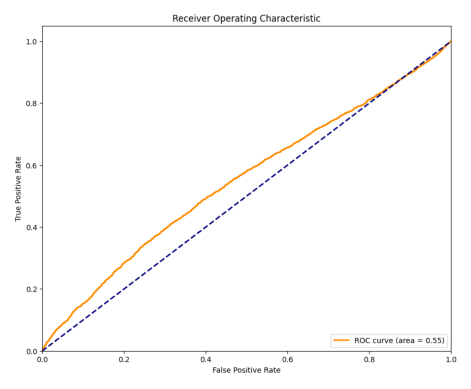

In [3]:
gru_test_model(model, test_loader)

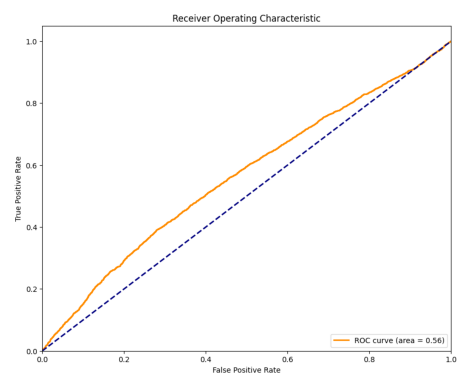

In [4]:
gru_test_model(model, forward_test_loader)